# **Notebook for plotting results generated with GRRR notebooks**

First, we import all the results we want into a workable structure so we can easily index dimensions we need for plots

In [6]:
from typing import List, Tuple, Dict, Any
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [7]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Georgia'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Georgia'
mpl.rcParams['mathtext.it'] = 'Georgia:italic'
mpl.rcParams['mathtext.bf'] = 'Georgia:bold'

In [8]:
# # loop through all files in ../data/results/ and if it starts with GloFAS or PTM, look in the string for
# # the final sequence that is a float OR int, change it to int if it is NOT a '1.5', and add rp to it
# # if below 90, else add pc to it

# from pathlib import Path
# import re

# # folder containing the result files
# results_dir = Path("../data/results")

# # regex:
# #   group 1 -> everything up to the final number
# #   group 2 -> the final number (int or float)
# #   group 3 -> the extension, including the leading dot
# pattern = re.compile(r"^(.*?)(\d+(?:\.\d+)?)(\.[^.]+)$")

# for file_path in results_dir.iterdir():
#     if not file_path.is_file():
#         continue

#     fname = file_path.name
#     if not fname.startswith(("GloFAS", "PTM")):
#         continue

#     m = pattern.match(fname)
#     if m is None:          # no trailing number – skip
#         continue

#     head, num_str, ext = m.groups()

#     # ------------------------------------------------------------------
#     # 1. keep '1.5' as is; otherwise turn the number into an integer
#     # ------------------------------------------------------------------
#     if num_str == "1.5":
#         num_val        = 1.5
#         num_str_fixed  = "1.5"
#     else:
#         num_val        = int(float(num_str))   # handles '12' or '12.0'
#         num_str_fixed  = str(num_val)

#     # ------------------------------------------------------------------
#     # 2. choose the suffix
#     # ------------------------------------------------------------------
#     suffix = "rp" if num_val < 90 else "pc"

#     new_name = f"{head}{num_str_fixed}{suffix}{ext}"

#     # skip renaming if nothing changes
#     if new_name == fname:
#         continue

#     # ------------------------------------------------------------------
#     # 3. rename the file
#     # ------------------------------------------------------------------
#     new_path = file_path.with_name(new_name)
#     file_path.rename(new_path)
#     print(f"{fname}  →  {new_name}")


In [9]:
def read_results(
    model: str,                 # either 'GFH' or 'GloFAS_v3' or 'GloFAS_v4'
    type: str,                  # either 'IMPACT' or 'OBS'
    geojson: bool = False,      # if True, returns the results with GeoJSON information included
                                # list of lead times to read the results for
    lead_time: List[int] = [4, 5, 6, 7],
                                # list of return periods to read the results for
    return_period: List[float] = [1.5, 2, 5, 10, 95, 98, 99]
) -> Dict[str, pd.DataFrame]:
    """ Reads the results from the .csv files and return in dictionary with handy keys """
    if model not in ['GFH', 'GloFAS3', 'GloFAS', 'PTM']:
        raise ValueError("Model must be either 'GFH', 'GloFAS3', 'GloFAS', or 'PTM'")
    if type not in ['IMPACT', 'OBS']:
        raise ValueError("Type must be either 'IMPACT' or 'OBS'")
    if not all(lt in [1, 2, 3, 4, 5, 6, 7] for lt in lead_time):
        raise ValueError("Lead time must be in [1, 2, 3, 4, 5, 6, 7]")
    if not all(rp in [1.5, 2, 5, 10, 95, 98, 99] for rp in return_period):
        raise ValueError("Return period must be in [1.5, 2, 5, 10, 95, 98, 99]")

    if model == 'PTM':
        print("Model type is PTM, so only 4 days lead time and 1.5, 2, 5, 95, 98, 99 return periods are available")
        lead_time = [4]
        return_period = [1.5, 2, 5, 95, 98, 99]

    print(model, type)
    d = {}
    for lt in lead_time:
        for rp in return_period:
            if rp in [1.5, 2, 5, 10]:
                rp_str = f'{rp}rp'
            elif rp in [95, 98, 99]:
                rp_str = f'{rp}pc'

            if not geojson:
                key = f'{model}_vs_{type}_{lt * 24}lt_{rp_str}'
                d[key] = pd.read_csv(f'../data/results/{key}.csv', index_col = 0)
            else:
                key = f'{model}_vs_{type}_{lt * 24}lt_{rp_str}'
                d[key] = gpd.read_file(f'../data/results_geojson/{key}.geojson')

            # Warning: LLM-generated code from hereon in this function:
            def safe_div(num, den):    
                return np.where(den == 0, np.nan, num / den)
            if model in ("GloFAS3", "GloFAS"):
                cols = ['identifier', 'TP', 'FP', 'FN']
                df = d[key][cols].loc[d[key]['identifier'] != 'GUELELINKORO'].copy()
                total = df[['TP', 'FP', 'FN']].sum()
                total['identifier'] = 'total'
                df = pd.concat([df, total.to_frame().T], ignore_index=True)
                tp   = df['TP'].astype(float)
                fp   = df['FP'].astype(float)
                fn   = df['FN'].astype(float)
                den_pod = tp + fn          # TP + FN
                den_far = tp + fp          # TP + FP
                df['POD']       = safe_div(tp, den_pod)
                df['FAR']       = safe_div(fp, den_far)
                df['precision'] = safe_div(tp, den_far)
                df['F1'] = np.where(
                    (df['precision'] + df['POD']) == 0,
                    np.nan,
                    2 * (df['precision'] * df['POD']) / (df['precision'] + df['POD'])
                )
                d[key] = df
    return d

In [10]:
d_GFH_IMPACT = read_results(model = 'GFH', type = 'IMPACT')

print(next(iter(d_GFH_IMPACT.values())).head())

GFH IMPACT
  identifier  TP  FP  FN    POD  FAR  precision     f1 admin_unit_NAME
0     ML0101   0   0   1  0.000  NaN        NaN    NaN       BAFOULABE
1     ML0103   0   2   3  0.000  1.0        0.0    NaN          SANDIA
2     ML0105   0   1   1  0.000  1.0        0.0    NaN            KITA
3     ML0107   0   0   2  0.000  NaN        NaN    NaN        YELIMANE
4     ML0202   1   0   5  0.167  0.0        1.0  0.286          DIOILA


In [11]:
d_PTM_OBS = read_results(model = 'PTM', type = 'OBS')

Model type is PTM, so only 4 days lead time and 1.5, 2, 5, 95, 98, 99 return periods are available
PTM OBS


In [12]:
def get_metrics_for_configuration(
        d: Dict[str, pd.DataFrame], # the dictionary with the results
        type: str,                  # the type of results, e.g. 'GFH_vs_IMPACT'
        row: str,                   # where to get the metric for, i.e. in 'identifier' a location or 'total'
        metric: str,                # the metric to calculate (TP, FP, FN, POD, FAR, precision, f1)
    ) -> pd.DataFrame:
    """ Returns metric dataframe with dimensions (lead_time, return_period) """
    if not any(key.startswith(type) for key in d.keys()):
        raise ValueError("Type must be in the keys of the dictionary")
    if row not in next(iter(d.values()))['identifier'].unique():
        raise ValueError("Row must be in the identifier column of the dataframe")
    if metric not in ['TP', 'FP', 'FN', 'POD', 'FAR', 'precision', 'f1']:
        raise ValueError("Metric must be in ['TP', 'FP', 'FN', 'POD', 'FAR', 'precision', 'f1']")
    
    lts = ['96lt', '120lt', '144lt', '168lt']
    rps = ['95pc', '98pc', '99pc', '1.5rp', '2rp', '5rp', '10rp']
    df = pd.DataFrame(index = lts, columns = rps)
    
    for lt in lts:
        for rp in rps:
            key = f'{type}_{lt}_{rp}'
            df.loc[lt, rp] = d[key][d[key]['identifier'] == row][metric].values[0]
    return df

In [13]:
df_GFH_IMPACT_POD_total = get_metrics_for_configuration(
    d               = d_GFH_IMPACT,
    type            = 'GFH_vs_IMPACT',
    row             = 'total',
    metric          = 'POD'
)

print(df_GFH_IMPACT_POD_total)

        95pc   98pc   99pc  1.5rp    2rp    5rp   10rp
96lt     0.2  0.118  0.064  0.155  0.109  0.036  0.009
120lt  0.173  0.109  0.055  0.155  0.109  0.036  0.009
144lt  0.182    0.1  0.055  0.136  0.109  0.036  0.009
168lt  0.182  0.109  0.055  0.155  0.118  0.036  0.009


In [14]:
from typing import Optional, Sequence

def add_hline_across_subplots(fig, ax_ref, y, ax_left, ax_right, label, **line_kwargs):
    # LLM-generated code:
    import matplotlib.lines as mlines
    display_coords = ax_ref.transData.transform((0, y))
    y_fig = fig.transFigure.inverted().transform(display_coords)[1]
    bbox_left  = ax_left.get_position()
    bbox_right = ax_right.get_position()
    line = mlines.Line2D([bbox_left.x0, bbox_right.x1],
                         [y_fig, y_fig],
                         transform = fig.transFigure, **line_kwargs)
    fig.add_artist(line)

    if label:
        dummy_text = fig.text(0, 0, label, fontsize = 12)
        fig.canvas.draw()
        renderer = fig.canvas.get_renderer()
        bbox = dummy_text.get_window_extent(renderer=renderer)
        text_width_pixels = bbox.width
        fig_width_pixels = fig.get_figwidth() * fig.dpi
        text_width_frac = text_width_pixels / fig_width_pixels
        dummy_text.remove()
        x_text = bbox_right.x1 - text_width_frac
        fig.text(x_text - 0.005, y_fig + 0.015, label,
                 fontsize = 12, color = line_kwargs['color'])


# LLM-generated code:
def annotate_plot_point(ax, xs, ys, labels, color, place_below=None):
    if place_below is None:
        place_below = set()
    for x, y, lab in zip(xs, ys, labels):
        # normalize for comparison (handle numbers or strings)
        lab_norm = None
        try:
            lab_norm = int(lab)
        except Exception:
            lab_norm = str(lab).strip()

        if (lab_norm in place_below) or (str(lab_norm) in {str(v) for v in place_below}):
            offset = (0, -6); va = 'top'     # put label below the point
        else:
            offset = (0,  6); va = 'bottom'  # default: above the point

        ax.annotate(
            str(lab), (x, y),
            xytext=offset, textcoords='offset points',
            ha='center', va=va,
            fontsize=10, color=color, clip_on=True
        )

        
def plot_PODFAR_over_treshold(
        dfs: List[pd.DataFrame], # dataframes with the results
        names: List[str],        # names of the dataframes, e.g. ['GloFAS', 'GFH']
        row_to_plot,        # the row to plot, e.g. 'total' or a certain location
        y_str: str,         # y and x for naming the saved plot
        x_str: str,
        save_figure: bool = False,
        lead_time: int = 7, # lead time in days 
        sample_sizes: Optional[List[Sequence]] = None,
        place_below: Optional[set] = None            
    ) -> None:
    """ Plots the POD over the thresholds """
    if len(dfs) != len(names):
        raise ValueError("Length of dfs and names must be equal")
    if sample_sizes is not None and len(sample_sizes) != len(dfs):
        raise ValueError("When provided, sample_sizes must have the same length as dfs")
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (4 * 1.618, 4))
    fig.subplots_adjust(wspace = 0.05)
    fs = 12

    colours = ['blue', 'red', 'magenta', 'black']
    markers = ['^', 's', 'D', 'o', 'v', 'x']
    for idx, (df, label) in enumerate(zip(dfs, names)):
        # x_vals = np.arange(len(df.columns))
        # y_vals = df.loc[row_to_plot, df.columns].values
        mk     = markers[idx % len(markers)]
        col    = colours[idx % len(colours)]

        s = pd.to_numeric(df.loc[row_to_plot, df.columns],
                          errors = 'coerce')  
        x = np.arange(len(s))
        segment_L = s.iloc[0:3]
        mL = segment_L.notna() & segment_L.ne(0)
        ax1.plot(x[0:3][mL], segment_L.to_numpy()[mL], marker = mk, color = col, label = label)
        segment_R = s.iloc[3:7]
        mR = segment_R.notna() & segment_R.ne(0)
        ax2.plot(x[3:7][mR], segment_R.to_numpy()[mR], marker = mk, color=col)

        # ax1.plot(x_vals[:3], y_vals[:3],
        #         marker = mk, color = col, label = label)
        
        # ax2.plot(x_vals[3 : 7], y_vals[3 : 7],
        #         marker = mk, color = col)

        # LLM-generated code-block:
        if sample_sizes is not None:
            labs = list(sample_sizes[idx])
            if len(labs) < 7:
                labs = labs + [None] * (7 - len(labs))
            n_labels = np.array(labs, dtype=object)
            mL_bool = np.asarray(mL, dtype=bool)
            xs_L = x[0:3][mL_bool]
            ys_L = segment_L.to_numpy()[mL_bool]
            labs_L = n_labels[:3][mL_bool]
            mask_L = np.array([lab is not None and lab != "" for lab in labs_L], dtype=bool)
            annotate_plot_point(ax1, xs_L[mask_L], ys_L[mask_L], labs_L[mask_L], col)
            mR_bool = np.asarray(mR, dtype=bool)
            xs_R = x[3:7][mR_bool]
            ys_R = segment_R.to_numpy()[mR_bool]
            labs_R = n_labels[3:7][mR_bool]
            mask_R = np.array([lab is not None and lab != "" for lab in labs_R], dtype=bool)
            annotate_plot_point(ax2, xs_R[mask_R], ys_R[mask_R], labs_R[mask_R], col,
                                place_below=place_below)


    # if y_str contains POD, set the y-label to 'Probability of Detection (POD)'

    if 'POD' in y_str:
        ax1.set_ylabel('mean POD [-]', fontsize = fs)
        y_str = 'POD'
    elif 'FAR' in y_str:
        ax1.set_ylabel('mean FAR [-]', fontsize = fs)
        y_str = 'FAR'
    # ax1.set_ylabel(y_str, fontsize = fs)

    # columns = df.columns
    # x_values = np.arange(len(columns))
    # y_values = df.loc[row_to_plot, columns].values

    # ax1.plot(
    #     x_values[0 : 3], y_values[0 : 3],
    #     color = 'blue', marker = '^', label = 'Google Flood Hub'
    # )
    # ax2.plot(
    #     x_values[3 : 7], y_values[3 : 7],
    #     color = 'blue', marker = '^'
    # )

    plt.tight_layout() # Note: place this at the right place in the script to not mess up manual lay-outing

    ax1.set_xlim(-0.5, 2.5)
    ax2.set_xlim(2.5, 6.5)
    ax1.set_xticks([0, 1, 2], fontsize = fs)
    ax1.set_xticklabels(['95%', '98%', '99%'], fontsize = fs)
    ax2.set_xticks([3, 4, 5, 6], fontsize = fs)
    ax2.set_xticklabels(['1.5-yr', '2-yr', '5-yr', '10-yr'], fontsize = fs)
    ax1.tick_params(axis = 'y', labelsize = fs)
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.yaxis.tick_left()
    ax2.yaxis.tick_right()
    ax1.set_ylim(0, 1) if y_str == 'POD' else ax1.set_ylim(1, 0)
    ax1.legend(loc = 'upper left', fontsize = fs, frameon = False)
    ax1.text(0.00, 1.05, f'Lead time = {lead_time} days', ha = 'left', va = 'top',
        transform = ax1.transAxes, fontsize = fs
    )
    ax1.spines['bottom'].set_zorder(0) # move bottom spine to back in case of y = 0 data points
    ax2.spines['bottom'].set_zorder(0)

    add_hline_across_subplots(
            fig, ax1, 0.5, ax1, ax2, label = "'Acceptable'",
            color = '#EB5B00', linestyle = '--', linewidth = 1.0
        )
    if y_str == 'POD':
        add_hline_across_subplots(
            fig, ax1, 0.6, ax1, ax2, label = "'Good'",
            color = '#0D4715', linestyle = '--', linewidth = 1.0
        )
    elif y_str == 'FAR':
        add_hline_across_subplots(
            fig, ax1, 0.3, ax1, ax2, label = "'Good'",
            color = '#0D4715', linestyle = '--', linewidth = 1.0
        )

    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
    d = 0.015
    kwargs = dict(transform = ax1.transAxes, color = 'k', clip_on = False)
    ax1.plot((1 - d, 1 + d), (-d, d), **kwargs)
    ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
    kwargs = dict(transform = ax2.transAxes, color = 'k', clip_on = False)
    ax2.plot((-d, d), (1 - d, 1 + d), **kwargs)        
    ax2.plot((-d, d), (-d, d), **kwargs) 
    # --------------------------------------------------------------------------------

    if 'POD' in y_str:
        y_str = 'POD'
    if 'FAR' in y_str:
        y_str = 'FAR'
    if save_figure:
        plt.savefig(f'../data/figures/results_{y_str}_vs_{x_str}_{row_to_plot}_total.pdf',
                    bbox_inches = 'tight', dpi = 300)
    plt.show()

        95pc   98pc   99pc  1.5rp    2rp    5rp   10rp
96lt     0.2  0.118  0.064  0.155  0.109  0.036  0.009
120lt  0.173  0.109  0.055  0.155  0.109  0.036  0.009
144lt  0.182    0.1  0.055  0.136  0.109  0.036  0.009
168lt  0.182  0.109  0.055  0.155  0.118  0.036  0.009


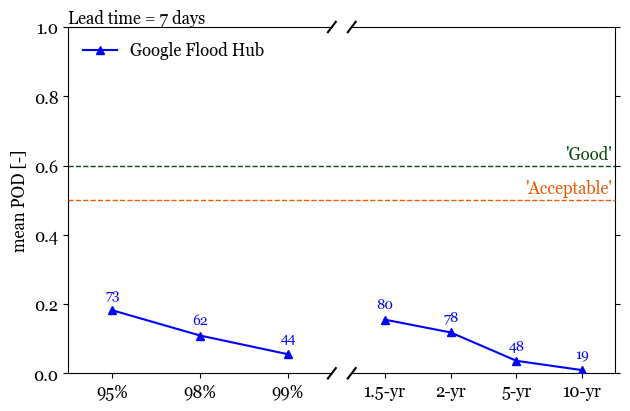

In [15]:
df_GFH_IMPACT_POD_total = get_metrics_for_configuration(
    d               = d_GFH_IMPACT,
    type            = 'GFH_vs_IMPACT',
    row             = 'total',
    metric          = 'POD'
)

print(df_GFH_IMPACT_POD_total)

plot_PODFAR_over_treshold(
    dfs             = [df_GFH_IMPACT_POD_total],
    names           = ['Google Flood Hub'],
    row_to_plot     = '168lt',
    y_str           = 'mean POD [-]',
    x_str           = 'thr',
    save_figure     = False,
    sample_sizes    = [[73, 62, 44, 80, 78, 48, 19]]
)

GFH OBS
        95pc   98pc   99pc  1.5rp    2rp    5rp 10rp
96lt   0.309  0.333  0.312  0.543  0.645  0.625  0.8
120lt  0.309  0.364  0.312  0.543  0.645  0.625  0.8
144lt  0.309  0.303  0.312  0.543  0.645  0.625  0.8
168lt  0.309  0.303  0.312  0.543  0.645  0.625  0.8
GloFAS OBS
GloFAS3 OBS


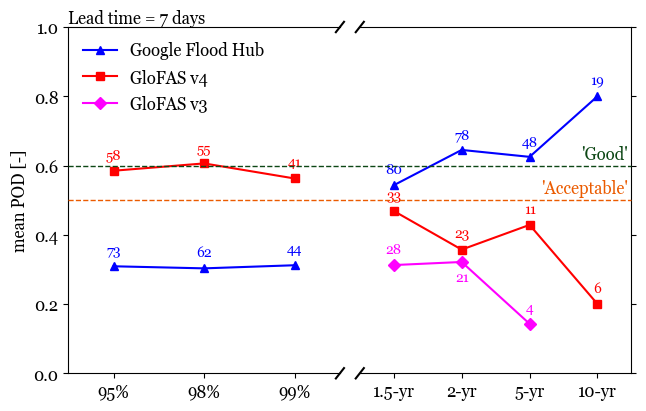

In [ ]:
d_GFH_OBS = read_results(model = 'GFH', type = 'OBS')
df_GFH_OBS_POD_total = get_metrics_for_configuration(d = d_GFH_OBS, type = 'GFH_vs_OBS',
                                                     row = 'total', metric = 'POD')
print(df_GFH_OBS_POD_total) 

d_GloFAS_v4_OBS = read_results(model = 'GloFAS', type = 'OBS')
df_GloFAS_v4_OBS_POD_total = get_metrics_for_configuration(d = d_GloFAS_v4_OBS, type = 'GloFAS_vs_OBS',
                                                           row = 'total', metric = 'POD')

d_GloFAS_v3_OBS = read_results(model = 'GloFAS3', type = 'OBS')
df_GloFAS_v3_OBS_POD_total = get_metrics_for_configuration(d = d_GloFAS_v3_OBS, type = 'GloFAS3_vs_OBS',
                                                           row = 'total', metric = 'POD')

plot_PODFAR_over_treshold(dfs = [df_GFH_OBS_POD_total,
                                 df_GloFAS_v4_OBS_POD_total,
                                 df_GloFAS_v3_OBS_POD_total],
                          names = ['Google Flood Hub',
                                   'GloFAS v4',
                                   'GloFAS v3'],
                          row_to_plot = '168lt',
                          y_str = 'POD',
                          x_str = 'thr',
                          save_figure = False,
                          sample_sizes = [
                              [73, 62, 44, 80, 78, 48, 19],
                              [58, 55, 41, 33, 23, 11, 6],
                              ['', '', '', 28, 21, 4, 0]
                          ],
                          place_below = {21})

GFH OBS
        95pc   98pc   99pc  1.5rp    2rp    5rp 10rp
96lt   0.309  0.333  0.312  0.543  0.645  0.625  0.8
120lt  0.309  0.364  0.312  0.543  0.645  0.625  0.8
144lt  0.309  0.303  0.312  0.543  0.645  0.625  0.8
168lt  0.309  0.303  0.312  0.543  0.645  0.625  0.8
GloFAS OBS
GloFAS3 OBS


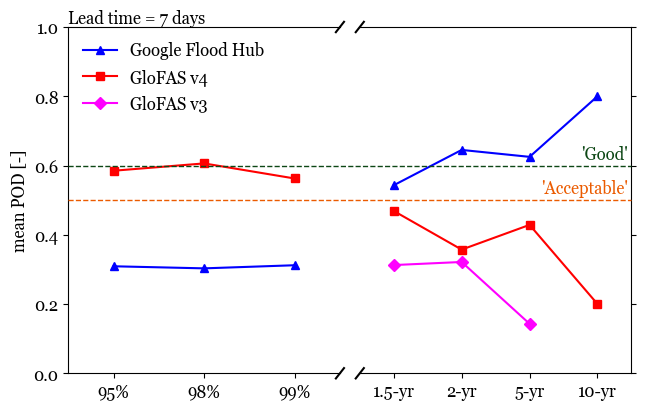

In [17]:
d_GFH_OBS = read_results(model = 'GFH', type = 'OBS')
df_GFH_OBS_POD_total = get_metrics_for_configuration(d = d_GFH_OBS, type = 'GFH_vs_OBS',
                                                     row = 'total', metric = 'POD')
print(df_GFH_OBS_POD_total) 

d_GloFAS_v4_OBS = read_results(model = 'GloFAS', type = 'OBS')
df_GloFAS_v4_OBS_POD_total = get_metrics_for_configuration(d = d_GloFAS_v4_OBS, type = 'GloFAS_vs_OBS',
                                                           row = 'total', metric = 'POD')

d_GloFAS_v3_OBS = read_results(model = 'GloFAS3', type = 'OBS')
df_GloFAS_v3_OBS_POD_total = get_metrics_for_configuration(d = d_GloFAS_v3_OBS, type = 'GloFAS3_vs_OBS',
                                                           row = 'total', metric = 'POD')

# d_PTM_OBS = read_results(model = 'PTM', type = 'OBS')
# df_PTM_OBS_POD_total = get_metrics_for_configuration(d = d_PTM_OBS, type = 'PTM_vs_OBS',
#                                                      row = 'BAMAKO', metric = 'POD')

plot_PODFAR_over_treshold(dfs = [df_GFH_OBS_POD_total,
                                 df_GloFAS_v4_OBS_POD_total,
                                 df_GloFAS_v3_OBS_POD_total],
                          names = ['Google Flood Hub',
                                   'GloFAS v4',
                                   'GloFAS v3'],
                          row_to_plot = '168lt',
                          y_str = 'POD',
                          x_str = 'thr')

In [20]:
# d_PTM_OBS = read_results(model = 'PTM', type = 'OBS')

# df_PTM_OBS_POD_total = get_metrics_for_configuration(d = d_PTM_OBS, type = 'PTM_vs_OBS',
#                                                      row = 'total', metric = 'POD')

In [21]:
print(d_PTM_OBS['PTM_vs_OBS_96lt_1.5rp'])

       identifier        Lat        Lon  Catchment area (km2)    Basin  pod  \
0    GUELELINKORO  11.150000  -8.564300                 23300    Niger  NaN   
1       BANANKORO  11.688980  -8.665260                 71800    Niger  NaN   
2          BAMAKO  12.631300  -7.998460                117000    Niger  1.0   
3       KOULIKORO  12.859333  -7.556389                120000    Niger  NaN   
4           MOPTI  14.488420  -4.205490                281600    Niger  NaN   
5            DIRE  16.279167  -3.383333                366500    Niger  NaN   
6        ANSONGO   15.664934   0.494453                566000    Niger  NaN   
7             GAO  16.266670  -0.050000                556000    Niger  NaN   
8          SOFARA  14.013930  -4.242900                129400    Niger  NaN   
9           DOUNA  13.217252  -5.899745                101300    Niger  NaN   
10       BOUGOUNI  11.398210  -7.449700                   930    Niger  NaN   
11      PANKOUROU  11.448860  -6.576520             

        95pc   98pc   99pc  1.5rp    2rp    5rp   10rp
96lt   0.764  0.823  0.778  0.759  0.737    0.8  0.778
120lt  0.764  0.812  0.778  0.759   0.74  0.804    0.8
144lt  0.764  0.841  0.773  0.762   0.74    0.8  0.789
168lt  0.767  0.839  0.773  0.762  0.744  0.792  0.789
           95pc      98pc      99pc     1.5rp       2rp       5rp      10rp
96lt   0.423729  0.536585  0.482759   0.53125  0.615385  0.384615  0.714286
120lt  0.431034  0.577778  0.483871       0.5  0.583333  0.428571  0.833333
144lt  0.418182  0.577778  0.485714       0.5  0.541667  0.384615  0.833333
168lt  0.436364       0.6  0.485714  0.516129  0.545455  0.454545  0.833333
      95pc 98pc 99pc     1.5rp       2rp  5rp 10rp
96lt   NaN  NaN  NaN      0.56  0.526316  0.5  NaN
120lt  NaN  NaN  NaN  0.576923       0.5  0.5  NaN
144lt  NaN  NaN  NaN  0.565217  0.526316  0.5  NaN
168lt  NaN  NaN  NaN  0.583333      0.55  0.6  NaN


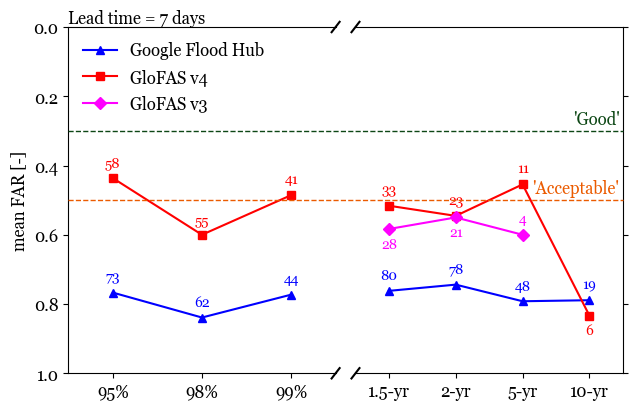

In [ ]:
df_GFH_OBS_FAR_total = get_metrics_for_configuration(d = d_GFH_OBS, type = 'GFH_vs_OBS',
                                                     row = 'total', metric = 'FAR')
print(df_GFH_OBS_FAR_total)

df_GloFAS_v4_OBS_FAR_total = get_metrics_for_configuration(d = d_GloFAS_v4_OBS, type = 'GloFAS_vs_OBS',
                                                           row = 'total', metric = 'FAR')
df_GloFAS_v3_OBS_FAR_total = get_metrics_for_configuration(d = d_GloFAS_v3_OBS, type = 'GloFAS3_vs_OBS',
                                                              row = 'total', metric = 'FAR')
print(df_GloFAS_v4_OBS_FAR_total)
print(df_GloFAS_v3_OBS_FAR_total)

plot_PODFAR_over_treshold(dfs = [df_GFH_OBS_FAR_total,
                                 df_GloFAS_v4_OBS_FAR_total,
                                 df_GloFAS_v3_OBS_FAR_total],
                          names = ['Google Flood Hub',
                                   'GloFAS v4',
                                   'GloFAS v3'],
                          row_to_plot = '168lt',
                          y_str = 'FAR',
                          x_str = 'thr',
                          save_figure = False,
                          sample_sizes = [
                              [73, 62, 44, 80, 78, 48, 19],
                              [58, 55, 41, 33, 23, 11, 6],
                              ['', '', '', 28, 21, 4, 0]
                          ],
                          place_below = {28, 21, 6})

### **Precision vs recall / POD vs (1 - FAR)**

In [23]:
thrs_rp = ['1.5rp', '2rp', '5rp', '10rp']
thrs_pc = ['95pc', '98pc', '99pc']

df_GFH_OBS_POD_total_rp = df_GFH_OBS_POD_total[thrs_rp]
df_GFH_OBS_POD_total_pc = df_GFH_OBS_POD_total[thrs_pc]

df_GFH_OBS_FAR_total_rp = df_GFH_OBS_FAR_total[thrs_rp]
df_GFH_OBS_FAR_total_pc = df_GFH_OBS_FAR_total[thrs_pc]

print(df_GFH_OBS_POD_total_rp)
print(df_GFH_OBS_POD_total_pc)

       1.5rp    2rp    5rp 10rp
96lt   0.543  0.645  0.625  0.8
120lt  0.543  0.645  0.625  0.8
144lt  0.543  0.645  0.625  0.8
168lt  0.543  0.645  0.625  0.8
        95pc   98pc   99pc
96lt   0.309  0.333  0.312
120lt  0.309  0.364  0.312
144lt  0.309  0.303  0.312
168lt  0.309  0.303  0.312


### **POD/FAR vs lead time**

        95pc   98pc   99pc  1.5rp    2rp    5rp 10rp
96lt   0.309  0.333  0.312  0.543  0.645  0.625  0.8
120lt  0.309  0.364  0.312  0.543  0.645  0.625  0.8
144lt  0.309  0.303  0.312  0.543  0.645  0.625  0.8
168lt  0.309  0.303  0.312  0.543  0.645  0.625  0.8
      95pc 98pc 99pc    1.5rp       2rp       5rp 10rp
96lt   0.0  0.0  0.0  0.34375  0.321429  0.214286  0.0
120lt  0.0  0.0  0.0  0.34375  0.321429  0.214286  0.0
144lt  0.0  0.0  0.0   0.3125  0.321429  0.142857  0.0
168lt  0.0  0.0  0.0   0.3125  0.321429  0.142857  0.0
           95pc      98pc     99pc    1.5rp       2rp       5rp 10rp
96lt   0.641509  0.575758  0.46875  0.46875  0.357143  0.571429  0.4
120lt  0.622642  0.575758      0.5      0.5  0.357143  0.571429  0.2
144lt  0.603774  0.575758   0.5625  0.53125  0.392857  0.571429  0.2
168lt  0.584906  0.606061   0.5625  0.46875  0.357143  0.428571  0.2
plotted column 95pc linestyle -
plotted column 1.5rp linestyle --
plotted column 5rp linestyle :


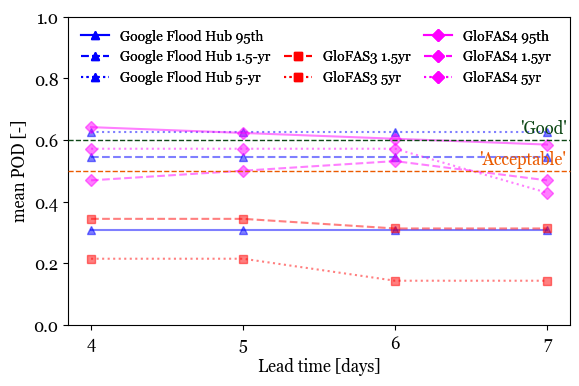

In [24]:
print(df_GFH_OBS_POD_total)
# print(df_GFH_OBS_FAR_total)
print(df_GloFAS_v3_OBS_POD_total)
# print(df_GloFAS_v3_OBS_FAR_total)
print(df_GloFAS_v4_OBS_POD_total)
# print(df_GloFAS_v4_OBS_FAR_total)

# select only the 95pc, 1.5rp, 5rp columns
df_GFH_OBS_POD_total_subset = df_GFH_OBS_POD_total.loc[:, ['95pc', '1.5rp', '5rp']]
df_GFH_OBS_FAR_total_subset = df_GFH_OBS_FAR_total.loc[:, ['95pc', '1.5rp', '5rp']]
df_GloFAS_v4_OBS_POD_total_subset = df_GloFAS_v4_OBS_POD_total.loc[:, ['95pc', '1.5rp', '5rp']]
df_GloFAS_v4_OBS_FAR_total_subset = df_GloFAS_v4_OBS_FAR_total.loc[:, ['95pc', '1.5rp', '5rp']]
df_GloFAS_v3_OBS_POD_total_subset = df_GloFAS_v3_OBS_POD_total.loc[:, ['95pc', '1.5rp', '5rp']]
df_GloFAS_v3_OBS_FAR_total_subset = df_GloFAS_v3_OBS_FAR_total.loc[:, ['95pc', '1.5rp', '5rp']]

# plot lead time on the x-axis and POD on the y-axis
fig, ax = plt.subplots(figsize = (4 * 1.618, 4))
fs = 12

# plot every line separately: take the index as x and take a column as y per plot:
linestyles = ['-', '--', ':']
alpha = 0.5
for col, ls in zip(df_GFH_OBS_POD_total_subset.columns, linestyles):
    ax.plot(
        df_GFH_OBS_POD_total_subset.index, df_GFH_OBS_POD_total_subset[col],
        color = 'blue', marker = '^', linestyle = ls, alpha = alpha
    )
    print(f'plotted column {col} linestyle {ls}')
for col, ls in zip(df_GloFAS_v3_OBS_POD_total_subset.columns, linestyles):
    if col == '95pc':
        continue
    ax.plot(
        df_GloFAS_v3_OBS_POD_total_subset.index, df_GloFAS_v3_OBS_POD_total_subset[col],
        color = 'red', marker = 's', linestyle = ls, alpha = alpha
    )
for col, ls in zip(df_GloFAS_v4_OBS_POD_total_subset.columns, linestyles):
    ax.plot(
        df_GloFAS_v4_OBS_POD_total_subset.index, df_GloFAS_v4_OBS_POD_total_subset[col],
        color = 'magenta', marker = 'D', linestyle = ls, alpha = alpha
    )

ax.set_ylim(0, 1)
ax.tick_params(axis = 'y', labelsize = fs)
ax.set_ylabel('mean POD [-]', fontsize = fs)
ax.set_xticks(df_GFH_IMPACT_POD_total.index)
ax.set_xticklabels([4, 5, 6, 7], fontsize = fs)
ax.set_xlabel('Lead time [days]', fontsize = fs)

add_hline_across_subplots(
    fig, ax, 0.5, ax, ax, label = "'Acceptable'",
    color = '#EB5B00', linestyle = '--', linewidth = 1.0
)
add_hline_across_subplots(
    fig, ax, 0.6, ax, ax, label = "'Good'",
    color = '#0D4715', linestyle = '--', linewidth = 1.0
)

# add legend 
# add first legend
legend_handles_1 = [
    # GFH
     mpl.lines.Line2D([0], [0], color = 'blue', marker = '^', linestyle = '-'),
     mpl.lines.Line2D([0], [0], color = 'blue', marker = '^', linestyle = '--'),
     mpl.lines.Line2D([0], [0], color = 'blue', marker = '^', linestyle = ':'),
    # GloFAS v3
    #  mpl.lines.Line2D([0], [0], color = 'red', marker = 's', linestyle = '-'),
     mpl.lines.Line2D([0], [0], marker = 's', linestyle = 'None',
                     markerfacecolor = 'none', markeredgecolor = 'none'),
     mpl.lines.Line2D([0], [0], color = 'red', marker = 's', linestyle = '--'),
     mpl.lines.Line2D([0], [0], color = 'red', marker = 's', linestyle = ':'),
    # GloFAS v4
     mpl.lines.Line2D([0], [0], color = 'magenta', marker = 'D', linestyle = '-'),
     mpl.lines.Line2D([0], [0], color = 'magenta', marker = 'D', linestyle = '--'),
     mpl.lines.Line2D([0], [0], color = 'magenta', marker = 'D', linestyle = ':'),
]
legend_labels_1 = ['Google Flood Hub 95th', 'Google Flood Hub 1.5-yr', 'Google Flood Hub 5-yr',
                   '', 'GloFAS3 1.5yr', 'GloFAS3 5yr',
                   'GloFAS4 95th', 'GloFAS4 1.5yr', 'GloFAS4 5yr']
legend_1 = ax.legend(legend_handles_1, legend_labels_1,
          fontsize = fs - 2, ncol = 3, frameon = False, loc = 'upper left', columnspacing = 1)
ax.add_artist(legend_1)
# add second legend
# legend_handles_2 = [
#     mpl.lines.Line2D([0], [0], color = 'blue', marker = '^', linestyle = '-'),
#     mpl.lines.Line2D([0], [0], color = 'red', marker = 's', linestyle = '-'),
#     mpl.lines.Line2D([0], [0], color = 'magenta', marker = 'D', linestyle = '-'),
# ]
# legend_labels_2 = ['Google Flood Hub', 'GloFAS v3', 'GloFAS v4']
# legend_2 = ax.legend(legend_handles_2, legend_labels_2,
#           fontsize = fs, ncol = 3, frameon = False, loc = 'lower left',
#           columnspacing = 1)

# plt.savefig(f'../data/figures/results_POD_vs_leadtime.pdf',
#                 bbox_inches = 'tight', dpi = 300)
plt.show()

        95pc   98pc   99pc  1.5rp    2rp    5rp   10rp
96lt   0.764  0.823  0.778  0.759  0.737    0.8  0.778
120lt  0.764  0.812  0.778  0.759   0.74  0.804    0.8
144lt  0.764  0.841  0.773  0.762   0.74    0.8  0.789
168lt  0.767  0.839  0.773  0.762  0.744  0.792  0.789
      95pc 98pc 99pc     1.5rp       2rp  5rp 10rp
96lt   NaN  NaN  NaN      0.56  0.526316  0.5  NaN
120lt  NaN  NaN  NaN  0.576923       0.5  0.5  NaN
144lt  NaN  NaN  NaN  0.565217  0.526316  0.5  NaN
168lt  NaN  NaN  NaN  0.583333      0.55  0.6  NaN
           95pc      98pc      99pc     1.5rp       2rp       5rp      10rp
96lt   0.423729  0.536585  0.482759   0.53125  0.615385  0.384615  0.714286
120lt  0.431034  0.577778  0.483871       0.5  0.583333  0.428571  0.833333
144lt  0.418182  0.577778  0.485714       0.5  0.541667  0.384615  0.833333
168lt  0.436364       0.6  0.485714  0.516129  0.545455  0.454545  0.833333
plotted column 95pc linestyle -
plotted column 1.5rp linestyle --
plotted column 5rp lines

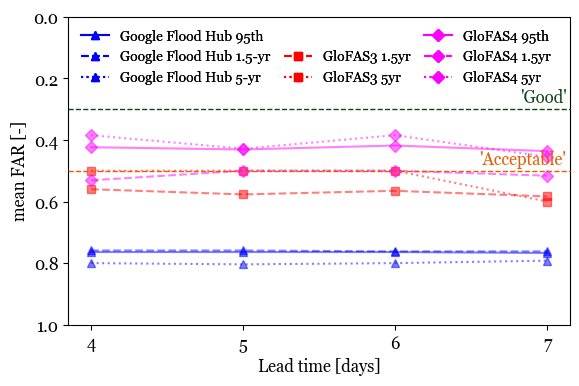

In [25]:
print(df_GFH_OBS_FAR_total)
print(df_GloFAS_v3_OBS_FAR_total)
print(df_GloFAS_v4_OBS_FAR_total)

# select only the 95pc, 1.5rp, 5rp columns
df_GFH_OBS_FAR_total_subset = df_GFH_OBS_FAR_total.loc[:, ['95pc', '1.5rp', '5rp']]
df_GloFAS_v3_OBS_FAR_total_subset = df_GloFAS_v3_OBS_FAR_total.loc[:, ['95pc', '1.5rp', '5rp']]
df_GloFAS_v4_OBS_FAR_total_subset = df_GloFAS_v4_OBS_FAR_total.loc[:, ['95pc', '1.5rp', '5rp']]

# plot lead time on the x-axis and POD on the y-axis
fig, ax = plt.subplots(figsize = (4 * 1.618, 4))
fs = 12

# plot every line separately: take the index as x and take a column as y per plot:
linestyles = ['-', '--', ':']
alpha = 0.5
for col, ls in zip(df_GFH_OBS_FAR_total_subset.columns, linestyles):
    ax.plot(
        df_GFH_OBS_FAR_total_subset.index, df_GFH_OBS_FAR_total_subset[col],
        color = 'blue', marker = '^', linestyle = ls, alpha = alpha
    )
    print(f'plotted column {col} linestyle {ls}')
for col, ls in zip(df_GloFAS_v3_OBS_FAR_total_subset.columns, linestyles):
    if col == '95pc':
        continue
    ax.plot(
        df_GloFAS_v3_OBS_FAR_total_subset.index, df_GloFAS_v3_OBS_FAR_total_subset[col],
        color = 'red', marker = 's', linestyle = ls, alpha = alpha
    )
for col, ls in zip(df_GloFAS_v4_OBS_FAR_total_subset.columns, linestyles):
    ax.plot(
        df_GloFAS_v4_OBS_FAR_total_subset.index, df_GloFAS_v4_OBS_FAR_total_subset[col],
        color = 'magenta', marker = 'D', linestyle = ls, alpha = alpha
    )

ax.set_ylim(0, 1)
ax.tick_params(axis = 'y', labelsize = fs)
ax.set_ylabel('mean FAR [-]', fontsize = fs)
ax.set_xticks(df_GFH_IMPACT_POD_total.index)
ax.set_xticklabels([4, 5, 6, 7], fontsize = fs)
ax.set_xlabel('Lead time [days]', fontsize = fs)
ax.set_ylim(1, 0)

add_hline_across_subplots(
    fig, ax, 0.5, ax, ax, label = "'Acceptable'",
    color = '#EB5B00', linestyle = '--', linewidth = 1.0
)
add_hline_across_subplots(
    fig, ax, 0.3, ax, ax, label = "'Good'",
    color = '#0D4715', linestyle = '--', linewidth = 1.0
)

# add legend 
# add first legend
legend_handles_1 = [
    # GFH
     mpl.lines.Line2D([0], [0], color = 'blue', marker = '^', linestyle = '-'),
     mpl.lines.Line2D([0], [0], color = 'blue', marker = '^', linestyle = '--'),
     mpl.lines.Line2D([0], [0], color = 'blue', marker = '^', linestyle = ':'),
    # GloFAS v3
    #  mpl.lines.Line2D([0], [0], color = 'red', marker = 's', linestyle = '-'),
     mpl.lines.Line2D([0], [0], marker = 's', linestyle = 'None',
                     markerfacecolor = 'none', markeredgecolor = 'none'),
     mpl.lines.Line2D([0], [0], color = 'red', marker = 's', linestyle = '--'),
     mpl.lines.Line2D([0], [0], color = 'red', marker = 's', linestyle = ':'),
    # GloFAS v4
     mpl.lines.Line2D([0], [0], color = 'magenta', marker = 'D', linestyle = '-'),
     mpl.lines.Line2D([0], [0], color = 'magenta', marker = 'D', linestyle = '--'),
     mpl.lines.Line2D([0], [0], color = 'magenta', marker = 'D', linestyle = ':'),
]
legend_labels_1 = ['Google Flood Hub 95th', 'Google Flood Hub 1.5-yr', 'Google Flood Hub 5-yr',
                   '', 'GloFAS3 1.5yr', 'GloFAS3 5yr',
                   'GloFAS4 95th', 'GloFAS4 1.5yr', 'GloFAS4 5yr']
legend_1 = ax.legend(legend_handles_1, legend_labels_1,
          fontsize = fs - 2, ncol = 3, frameon = False, loc = 'upper left', columnspacing = 1)
ax.add_artist(legend_1)
# add second legend
# legend_handles_2 = [
#     mpl.lines.Line2D([0], [0], color = 'blue', marker = '^', linestyle = '-'),
#     mpl.lines.Line2D([0], [0], color = 'red', marker = 's', linestyle = '-'),
#     mpl.lines.Line2D([0], [0], color = 'magenta', marker = 'D', linestyle = '-'),
# ]
# legend_labels_2 = ['Google Flood Hub', 'GloFAS v3', 'GloFAS v4']
# legend_2 = ax.legend(legend_handles_2, legend_labels_2,
#           fontsize = fs, ncol = 3, frameon = False, loc = 'lower left',
#           columnspacing = 1)
# plt.savefig(f'../data/figures/results_FAR_vs_leadtime.pdf',
#                 bbox_inches = 'tight', dpi = 300)
plt.show()

##### **Now plot all of them, but with a trend line**

        95pc   98pc   99pc  1.5rp    2rp    5rp 10rp
96lt   0.309  0.333  0.312  0.543  0.645  0.625  0.8
120lt  0.309  0.364  0.312  0.543  0.645  0.625  0.8
144lt  0.309  0.303  0.312  0.543  0.645  0.625  0.8
168lt  0.309  0.303  0.312  0.543  0.645  0.625  0.8
      95pc 98pc 99pc    1.5rp       2rp       5rp 10rp
96lt   0.0  0.0  0.0  0.34375  0.321429  0.214286  0.0
120lt  0.0  0.0  0.0  0.34375  0.321429  0.214286  0.0
144lt  0.0  0.0  0.0   0.3125  0.321429  0.142857  0.0
168lt  0.0  0.0  0.0   0.3125  0.321429  0.142857  0.0
           95pc      98pc     99pc    1.5rp       2rp       5rp 10rp
96lt   0.641509  0.575758  0.46875  0.46875  0.357143  0.571429  0.4
120lt  0.622642  0.575758      0.5      0.5  0.357143  0.571429  0.2
144lt  0.603774  0.575758   0.5625  0.53125  0.392857  0.571429  0.2
168lt  0.584906  0.606061   0.5625  0.46875  0.357143  0.428571  0.2


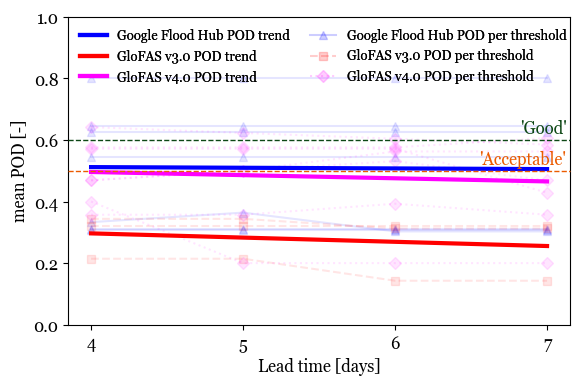

In [128]:
print(df_GFH_OBS_POD_total)
# print(df_GFH_OBS_FAR_total)
print(df_GloFAS_v3_OBS_POD_total)
# print(df_GloFAS_v3_OBS_FAR_total)
print(df_GloFAS_v4_OBS_POD_total)
# print(df_GloFAS_v4_OBS_FAR_total)

# plot lead time on the x-axis and POD on the y-axis
fig, ax = plt.subplots(figsize = (4 * 1.618, 4))
fs = 12


def plot_all_thresholds(ax, df, color, marker, ls = '-', alpha = 0.5,
                        exclude_cols: Optional[List[str]] = None):
    if exclude_cols is not None:
        df = df.drop(columns = exclude_cols)
    for col in df.columns:  
        ax.plot(
            df.index, df[col],
            color = color,
            marker = marker,
            linestyle = ls, alpha = alpha
        )

alpha = 0.1
exclude_cols_glofas3 = ['95pc', '98pc', '99pc', '10rp']
plot_all_thresholds(ax, df_GFH_OBS_POD_total,
                    'blue',    '^', '-', alpha = alpha)
plot_all_thresholds(ax, df_GloFAS_v3_OBS_POD_total,
                    'red',     's', '--', alpha = alpha,
                    exclude_cols = exclude_cols_glofas3)
plot_all_thresholds(ax, df_GloFAS_v4_OBS_POD_total,
                    'magenta', 'D', ':', alpha = alpha)

ax.set_ylim(0, 1)
ax.tick_params(axis = 'y', labelsize = fs)
ax.set_ylabel('mean POD [-]', fontsize = fs)
ax.set_xticks(df_GFH_IMPACT_POD_total.index)
ax.set_xticklabels([4, 5, 6, 7], fontsize = fs)
ax.set_xlabel('Lead time [days]', fontsize = fs)

add_hline_across_subplots(
    fig, ax, 0.5, ax, ax, label = "'Acceptable'",
    color = '#EB5B00', linestyle = '--', linewidth = 1.0
)
add_hline_across_subplots(
    fig, ax, 0.6, ax, ax, label = "'Good'",
    color = '#0D4715', linestyle = '--', linewidth = 1.0
)

# add legend 
# add first legend
legend_handles_1 = [
    # GFH trend
    mpl.lines.Line2D([0], [0], color = 'blue', linestyle = '-',
                     alpha = 1, linewidth = 3),
    # GloFAS v3 trend
    mpl.lines.Line2D([0], [0], color = 'red', linestyle = '-',
                     alpha = 1, linewidth = 3),
    # GloFAS v4 trend
    mpl.lines.Line2D([0], [0], color = 'magenta', linestyle = '-',
                     alpha = 1, linewidth = 3),
    # GFH
     mpl.lines.Line2D([0], [0], color = 'blue', marker = '^', linestyle = '-',
                      alpha = alpha + 0.0),
    # GloFAS v3
     mpl.lines.Line2D([0], [0], color = 'red', marker = 's', linestyle = '--',
                      alpha = alpha + 0.0),
    # GloFAS v4
     mpl.lines.Line2D([0], [0], color = 'magenta', marker = 'D', linestyle = ':',
                      alpha = alpha + 0.0),
]
legend_labels_1 = ['Google Flood Hub POD trend',
                   'GloFAS v3.0 POD trend',
                   'GloFAS v4.0 POD trend',
                   'Google Flood Hub POD per threshold',
                   'GloFAS v3.0 POD per threshold',
                   'GloFAS v4.0 POD per threshold']
legend_1 = ax.legend(legend_handles_1, legend_labels_1,
          fontsize = fs - 2.5, ncol = 2, frameon = False, loc = 'upper left',
          columnspacing = 1.5)
ax.add_artist(legend_1)

# LLM-generated code-block:
def add_mean_and_trend(ax, df, color, marker, label, exclude_cols=None,
                       place='above', xshift=100, yshift=6, fontsize=9):
    """
    Draws trend line (mean across thresholds vs lead time) and annotates it
    just above/below the **beginning** of the line (leftmost valid point).
    place: 'above' or 'below'
    """
    if exclude_cols is not None:
        df = df.loc[:, ~df.columns.isin(exclude_cols)]

    x_cat = list(df.index)                              # categorical x (lead times)
    vals  = df.apply(pd.to_numeric, errors='coerce')
    y_mean = vals.mean(axis=1).reindex(x_cat).to_numpy()

    x_num = np.arange(len(x_cat))
    msk = ~np.isnan(y_mean)
    if msk.sum() >= 2:
        m, b = np.polyfit(x_num[msk], y_mean[msk], 1)
        y_trend = m * x_num + b
    else:
        y_trend = np.full_like(x_num, np.nan, dtype=float)

    # plot trend
    ax.plot(x_cat, y_trend, color=color, linewidth=3, alpha=1, linestyle='-')

    # annotate at the **start** (first finite point)
    idx = np.where(np.isfinite(y_trend))[0]
    if len(idx) == 0:
        return
    i0 = idx[0]  # first finite point (leftmost)
    va = 'bottom' if place == 'above' else 'top'
    dy = yshift if place == 'above' else -yshift

    # ax.annotate(f"{label} trend", (x_cat[i0], y_trend[i0]),
    #             xytext=(xshift, dy), textcoords='offset points',
    #             ha='right', va=va, fontsize=fontsize,
    #             fontweight='bold', color=color)

add_mean_and_trend(ax, df_GFH_OBS_POD_total,       'blue',    '^',
                   'Google Flood Hub')
add_mean_and_trend(ax, df_GloFAS_v3_OBS_POD_total, 'red',     's',
                   'GloFAS v3.0',
                   exclude_cols = exclude_cols_glofas3)
add_mean_and_trend(ax, df_GloFAS_v4_OBS_POD_total, 'magenta', 'D',
                   'GloFAS v4.0',
                   place = 'below')

# plt.savefig(f'../data/figures/results_POD_trend_vs_leadtime.pdf',
#                 bbox_inches = 'tight', dpi = 300)
plt.show()

        95pc   98pc   99pc  1.5rp    2rp    5rp 10rp
96lt   0.309  0.333  0.312  0.543  0.645  0.625  0.8
120lt  0.309  0.364  0.312  0.543  0.645  0.625  0.8
144lt  0.309  0.303  0.312  0.543  0.645  0.625  0.8
168lt  0.309  0.303  0.312  0.543  0.645  0.625  0.8
      95pc 98pc 99pc    1.5rp       2rp       5rp 10rp
96lt   0.0  0.0  0.0  0.34375  0.321429  0.214286  0.0
120lt  0.0  0.0  0.0  0.34375  0.321429  0.214286  0.0
144lt  0.0  0.0  0.0   0.3125  0.321429  0.142857  0.0
168lt  0.0  0.0  0.0   0.3125  0.321429  0.142857  0.0
           95pc      98pc     99pc    1.5rp       2rp       5rp 10rp
96lt   0.641509  0.575758  0.46875  0.46875  0.357143  0.571429  0.4
120lt  0.622642  0.575758      0.5      0.5  0.357143  0.571429  0.2
144lt  0.603774  0.575758   0.5625  0.53125  0.392857  0.571429  0.2
168lt  0.584906  0.606061   0.5625  0.46875  0.357143  0.428571  0.2


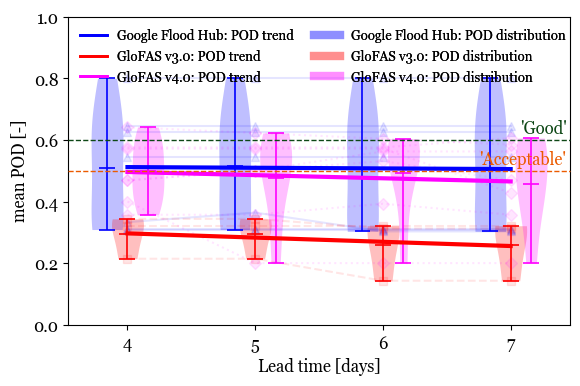

In [ ]:
print(df_GFH_OBS_POD_total)
# print(df_GFH_OBS_FAR_total)
print(df_GloFAS_v3_OBS_POD_total)
# print(df_GloFAS_v3_OBS_FAR_total)
print(df_GloFAS_v4_OBS_POD_total)
# print(df_GloFAS_v4_OBS_FAR_total)

# plot lead time on the x-axis and POD on the y-axis
fig, ax = plt.subplots(figsize = (4 * 1.618, 4))
fs = 12

def plot_all_thresholds(ax, df, color, marker, ls = '-', alpha = 0.5,
                        exclude_cols: Optional[List[str]] = None):
    if exclude_cols is not None:
        df = df.drop(columns = exclude_cols)
    for col in df.columns:  
        ax.plot(
            df.index, df[col],
            color = color,
            marker = marker,
            linestyle = ls, alpha = alpha
        )

alpha = 0.1
exclude_cols_glofas3 = ['95pc', '98pc', '99pc', '10rp']
plot_all_thresholds(ax, df_GFH_OBS_POD_total,
                    'blue',    '^', '-', alpha = alpha)
plot_all_thresholds(ax, df_GloFAS_v3_OBS_POD_total,
                    'red',     's', '--', alpha = alpha,
                    exclude_cols = exclude_cols_glofas3)
plot_all_thresholds(ax, df_GloFAS_v4_OBS_POD_total,
                    'magenta', 'D', ':', alpha = alpha)

ax.set_ylim(0, 1)
ax.tick_params(axis = 'y', labelsize = fs)
ax.set_ylabel('mean POD [-]', fontsize = fs)
ax.set_xticks(df_GFH_IMPACT_POD_total.index)
ax.set_xticklabels([4, 5, 6, 7], fontsize = fs)
ax.set_xlabel('Lead time [days]', fontsize = fs)

add_hline_across_subplots(
    fig, ax, 0.5, ax, ax, label = "'Acceptable'",
    color = '#EB5B00', linestyle = '--', linewidth = 1.0
)
add_hline_across_subplots(
    fig, ax, 0.6, ax, ax, label = "'Good'",
    color = '#0D4715', linestyle = '--', linewidth = 1.0
)

def pod_by_leadtime_arrays(df, exclude_cols=None):
    if exclude_cols is not None:
        df = df.loc[:, ~df.columns.isin(exclude_cols)]
    vals = df.apply(pd.to_numeric, errors='coerce')
    # returns list of 1D arrays, one per lead time in df.index order
    return [vals.loc[idx].dropna().to_numpy() for idx in vals.index]

pods_gfh   = pod_by_leadtime_arrays(df_GFH_OBS_POD_total)
pods_g3    = pod_by_leadtime_arrays(df_GloFAS_v3_OBS_POD_total,
                                    exclude_cols = exclude_cols_glofas3)
pods_g4    = pod_by_leadtime_arrays(df_GloFAS_v4_OBS_POD_total)

x_labels = list(df_GFH_OBS_POD_total.index)            # e.g. ['96lt','120lt','144lt','168lt']
x_numeric = np.arange(len(x_labels))                   # positions 0..3
xticks_display = [4,5,6,7]                             # pretty ticks in days

off = 0.16
pos_gfh = x_numeric - off
pos_g3  = x_numeric
pos_g4  = x_numeric + off

# LLM-generated function:
def draw_violins(ax, data_list, positions, color):
    v = ax.violinplot(data_list,
                      positions = positions,
                      showmeans = True,
                      showmedians = False,
                      showextrema = True,
                      widths = 0.25,
                      )
    # style
    for b in v['bodies']:
        b.set_facecolor(color)
        b.set_edgecolor(color)
        b.set_alpha(0.25)
        b.set_linewidth(0)
    v['cmeans'].set_color(color)
    v['cmeans'].set_linewidth(1.2)
    v['cbars'].set_color(color)
    v['cbars'].set_linewidth(1.2)
    v['cmins'].set_color(color)
    v['cmins'].set_linewidth(1.2)
    v['cmaxes'].set_color(color)
    v['cmaxes'].set_linewidth(1.2)

draw_violins(ax, pods_gfh, pos_gfh, 'blue')
draw_violins(ax, pods_g3,  pos_g3, 'red')
draw_violins(ax, pods_g4,  pos_g4, 'magenta')

# add first legend
legend_handles_1 = [
    # GFH trend
    mpl.lines.Line2D([0], [0], color = 'blue', linestyle = '-',
                     alpha = 1, linewidth = 2),
    # GloFAS v3 trend
    mpl.lines.Line2D([0], [0], color = 'red', linestyle = '-',
                     alpha = 1, linewidth = 2),
    # GloFAS v4 trend
    mpl.lines.Line2D([0], [0], color = 'magenta', linestyle = '-',
                     alpha = 1, linewidth = 2),
    # GFH violin
    mpl.lines.Line2D([0],[0], color = 'blue', lw = 6,
                            alpha = 0.25),
    # GloFAS v3 violin
    mpl.lines.Line2D([0],[0], color = 'red', lw = 6,
                            alpha = 0.25),
    # GloFAS v4 violin
    mpl.lines.Line2D([0],[0], color = 'magenta', lw = 6,
                            alpha = 0.25),
    # # GFH
    #  mpl.lines.Line2D([0], [0], color = 'blue', marker = '^', linestyle = '-',
    #                   alpha = alpha + 0.0),
    # # GloFAS v3
    #  mpl.lines.Line2D([0], [0], color = 'red', marker = 's', linestyle = '--',
    #                   alpha = alpha + 0.0),
    # # GloFAS v4
    #  mpl.lines.Line2D([0], [0], color = 'magenta', marker = 'D', linestyle = ':',
    #                   alpha = alpha + 0.0),
]
legend_labels_1 = ['Google Flood Hub: POD trend',
                   'GloFAS v3.0: POD trend',
                   'GloFAS v4.0: POD trend',
                     'Google Flood Hub: POD distribution',
                        'GloFAS v3.0: POD distribution',
                        'GloFAS v4.0: POD distribution'
                   ]
legend_1 = ax.legend(legend_handles_1, legend_labels_1,
          fontsize = fs - 2.5, ncol = 2, frameon = False, loc = 'upper left',
          columnspacing = 1.5)
ax.add_artist(legend_1)

# LLM-generated code-block:
def add_mean_and_trend(ax, df, color, marker, label, exclude_cols=None,
                       place='above', xshift=100, yshift=6, fontsize=9):
    """
    Draws trend line (mean across thresholds vs lead time) and annotates it
    just above/below the **beginning** of the line (leftmost valid point).
    place: 'above' or 'below'
    """
    if exclude_cols is not None:
        df = df.loc[:, ~df.columns.isin(exclude_cols)]

    x_cat = list(df.index)                              # categorical x (lead times)
    vals  = df.apply(pd.to_numeric, errors='coerce')
    y_mean = vals.mean(axis=1).reindex(x_cat).to_numpy()

    x_num = np.arange(len(x_cat))
    msk = ~np.isnan(y_mean)
    if msk.sum() >= 2:
        m, b = np.polyfit(x_num[msk], y_mean[msk], 1)
        y_trend = m * x_num + b
    else:
        y_trend = np.full_like(x_num, np.nan, dtype=float)

    ax.plot(x_cat, y_trend, color=color, linewidth=3, alpha=1, linestyle='-')


add_mean_and_trend(ax, df_GFH_OBS_POD_total,       'blue',    '^',
                   'Google Flood Hub')
add_mean_and_trend(ax, df_GloFAS_v3_OBS_POD_total, 'red',     's',
                   'GloFAS v3.0',
                   exclude_cols = exclude_cols_glofas3)
add_mean_and_trend(ax, df_GloFAS_v4_OBS_POD_total, 'magenta', 'D',
                   'GloFAS v4.0',
                   place = 'below')

# plt.savefig(f'../data/figures/results_POD_violin_trend_vs_leadtime.pdf',
#                 bbox_inches = 'tight', dpi = 300)
plt.show()

        95pc   98pc   99pc  1.5rp    2rp    5rp   10rp
96lt   0.764  0.823  0.778  0.759  0.737    0.8  0.778
120lt  0.764  0.812  0.778  0.759   0.74  0.804    0.8
144lt  0.764  0.841  0.773  0.762   0.74    0.8  0.789
168lt  0.767  0.839  0.773  0.762  0.744  0.792  0.789
      95pc 98pc 99pc     1.5rp       2rp  5rp 10rp
96lt   NaN  NaN  NaN      0.56  0.526316  0.5  NaN
120lt  NaN  NaN  NaN  0.576923       0.5  0.5  NaN
144lt  NaN  NaN  NaN  0.565217  0.526316  0.5  NaN
168lt  NaN  NaN  NaN  0.583333      0.55  0.6  NaN
           95pc      98pc      99pc     1.5rp       2rp       5rp      10rp
96lt   0.423729  0.536585  0.482759   0.53125  0.615385  0.384615  0.714286
120lt  0.431034  0.577778  0.483871       0.5  0.583333  0.428571  0.833333
144lt  0.418182  0.577778  0.485714       0.5  0.541667  0.384615  0.833333
168lt  0.436364       0.6  0.485714  0.516129  0.545455  0.454545  0.833333


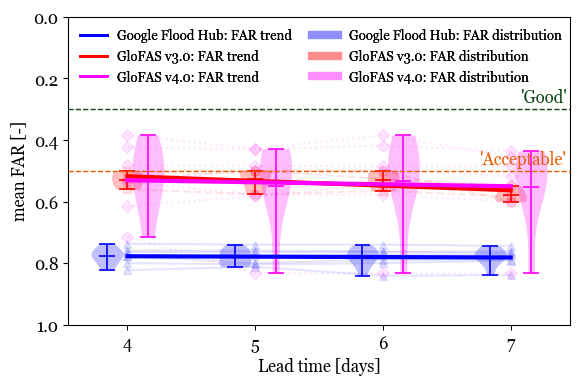

In [ ]:
# print(df_GFH_OBS_POD_total)
print(df_GFH_OBS_FAR_total)
# print(df_GloFAS_v3_OBS_POD_total)
print(df_GloFAS_v3_OBS_FAR_total)
# print(df_GloFAS_v4_OBS_POD_total)
print(df_GloFAS_v4_OBS_FAR_total)

# plot lead time on the x-axis and POD on the y-axis
fig, ax = plt.subplots(figsize = (4 * 1.618, 4))
fs = 12

def plot_all_thresholds(ax, df, color, marker, ls = '-', alpha = 0.5,
                        exclude_cols: Optional[List[str]] = None):
    if exclude_cols is not None:
        df = df.drop(columns = exclude_cols)
    for col in df.columns:  
        ax.plot(
            df.index, df[col],
            color = color,
            marker = marker,
            linestyle = ls, alpha = alpha
        )

alpha = 0.1
exclude_cols_glofas3 = ['95pc', '98pc', '99pc', '10rp']
plot_all_thresholds(ax, df_GFH_OBS_FAR_total,
                    'blue',    '^', '-', alpha = alpha)
plot_all_thresholds(ax, df_GloFAS_v3_OBS_FAR_total,
                    'red',     's', '--', alpha = alpha,
                    exclude_cols = exclude_cols_glofas3)
plot_all_thresholds(ax, df_GloFAS_v4_OBS_FAR_total,
                    'magenta', 'D', ':', alpha = alpha)

ax.set_ylim(0, 1)
ax.tick_params(axis = 'y', labelsize = fs)
ax.set_ylabel('mean FAR [-]', fontsize = fs)
ax.set_xticks(df_GFH_IMPACT_POD_total.index)
ax.set_xticklabels([4, 5, 6, 7], fontsize = fs)
ax.set_xlabel('Lead time [days]', fontsize = fs)
ax.set_ylim(1, 0)

add_hline_across_subplots(
    fig, ax, 0.5, ax, ax, label = "'Acceptable'",
    color = '#EB5B00', linestyle = '--', linewidth = 1.0
)
add_hline_across_subplots(
    fig, ax, 0.3, ax, ax, label = "'Good'",
    color = '#0D4715', linestyle = '--', linewidth = 1.0
)

def pod_by_leadtime_arrays(df, exclude_cols=None):
    if exclude_cols is not None:
        df = df.loc[:, ~df.columns.isin(exclude_cols)]
    vals = df.apply(pd.to_numeric, errors='coerce')
    # returns list of 1D arrays, one per lead time in df.index order
    return [vals.loc[idx].dropna().to_numpy() for idx in vals.index]

fars_gfh   = pod_by_leadtime_arrays(df_GFH_OBS_FAR_total)
fars_g3    = pod_by_leadtime_arrays(df_GloFAS_v3_OBS_FAR_total,
                                    exclude_cols = exclude_cols_glofas3)
fars_g4    = pod_by_leadtime_arrays(df_GloFAS_v4_OBS_FAR_total)

x_labels = list(df_GFH_OBS_FAR_total.index)            # e.g. ['96lt','120lt','144lt','168lt']
x_numeric = np.arange(len(x_labels))                   # positions 0..3
xticks_display = [4,5,6,7]                             # pretty ticks in days

off = 0.16
far_gfh = x_numeric - off
far_g3  = x_numeric
far_g4  = x_numeric + off

# LLM-generated function:
def draw_violins(ax, data_list, positions, color):
    v = ax.violinplot(data_list,
                      positions = positions,
                      showmeans = True,
                      showmedians = False,
                      showextrema = True,
                      widths = 0.25,
                      )
    # style
    for b in v['bodies']:
        b.set_facecolor(color)
        b.set_edgecolor(color)
        b.set_alpha(0.25)
        b.set_linewidth(0)
    v['cmeans'].set_color(color)
    v['cmeans'].set_linewidth(1.2)
    v['cbars'].set_color(color)
    v['cbars'].set_linewidth(1.2)
    v['cmins'].set_color(color)
    v['cmins'].set_linewidth(1.2)
    v['cmaxes'].set_color(color)
    v['cmaxes'].set_linewidth(1.2)

draw_violins(ax, fars_gfh, far_gfh, 'blue')
draw_violins(ax, fars_g3,  far_g3, 'red')
draw_violins(ax, fars_g4,  far_g4, 'magenta')

# add first legend
legend_handles_1 = [
    # GFH trend
    mpl.lines.Line2D([0], [0], color = 'blue', linestyle = '-',
                     alpha = 1, linewidth = 2),
    # GloFAS v3 trend
    mpl.lines.Line2D([0], [0], color = 'red', linestyle = '-',
                     alpha = 1, linewidth = 2),
    # GloFAS v4 trend
    mpl.lines.Line2D([0], [0], color = 'magenta', linestyle = '-',
                     alpha = 1, linewidth = 2),
    # GFH violin
    mpl.lines.Line2D([0],[0], color = 'blue', lw = 6,
                            alpha = 0.25),
    # GloFAS v3 violin
    mpl.lines.Line2D([0],[0], color = 'red', lw = 6,
                            alpha = 0.25),
    # GloFAS v4 violin
    mpl.lines.Line2D([0],[0], color = 'magenta', lw = 6,
                            alpha = 0.25),
    # # GFH
    #  mpl.lines.Line2D([0], [0], color = 'blue', marker = '^', linestyle = '-',
    #                   alpha = alpha + 0.0),
    # # GloFAS v3
    #  mpl.lines.Line2D([0], [0], color = 'red', marker = 's', linestyle = '--',
    #                   alpha = alpha + 0.0),
    # # GloFAS v4
    #  mpl.lines.Line2D([0], [0], color = 'magenta', marker = 'D', linestyle = ':',
    #                   alpha = alpha + 0.0),
]
legend_labels_1 = ['Google Flood Hub: FAR trend',
                   'GloFAS v3.0: FAR trend',
                   'GloFAS v4.0: FAR trend',
                     'Google Flood Hub: FAR distribution',
                        'GloFAS v3.0: FAR distribution',
                        'GloFAS v4.0: FAR distribution'
                   ]
legend_1 = ax.legend(legend_handles_1, legend_labels_1,
          fontsize = fs - 2.5, ncol = 2, frameon = False, loc = 'upper left',
          columnspacing = 1.5)
ax.add_artist(legend_1)

# LLM-generated code-block:
def add_mean_and_trend(ax, df, color, marker, label, exclude_cols=None,
                       place='above', xshift=100, yshift=6, fontsize=9):
    """
    Draws trend line (mean across thresholds vs lead time) and annotates it
    just above/below the **beginning** of the line (leftmost valid point).
    place: 'above' or 'below'
    """
    if exclude_cols is not None:
        df = df.loc[:, ~df.columns.isin(exclude_cols)]

    x_cat = list(df.index)                              # categorical x (lead times)
    vals  = df.apply(pd.to_numeric, errors='coerce')
    y_mean = vals.mean(axis=1).reindex(x_cat).to_numpy()

    x_num = np.arange(len(x_cat))
    msk = ~np.isnan(y_mean)
    if msk.sum() >= 2:
        m, b = np.polyfit(x_num[msk], y_mean[msk], 1)
        y_trend = m * x_num + b
    else:
        y_trend = np.full_like(x_num, np.nan, dtype=float)

    ax.plot(x_cat, y_trend, color=color, linewidth=3, alpha=1, linestyle='-')


add_mean_and_trend(ax, df_GFH_OBS_FAR_total,       'blue',    '^',
                   'Google Flood Hub')
add_mean_and_trend(ax, df_GloFAS_v3_OBS_FAR_total, 'red',     's',
                   'GloFAS v3.0',
                   exclude_cols = exclude_cols_glofas3)
add_mean_and_trend(ax, df_GloFAS_v4_OBS_FAR_total, 'magenta', 'D',
                   'GloFAS v4.0',
                   place = 'below')

# plt.savefig(f'../data/figures/results_FAR_violin_trend_vs_leadtime.pdf',
#                 bbox_inches = 'tight', dpi = 300)
plt.show()

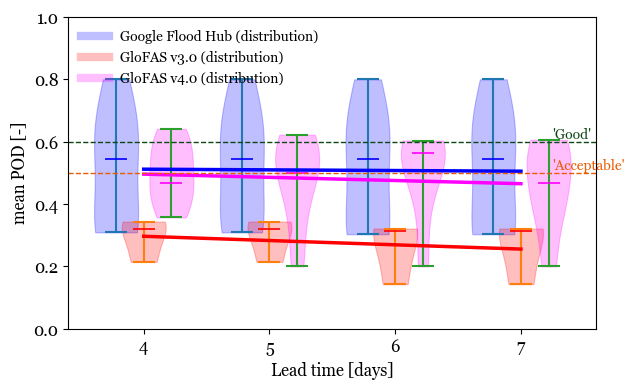

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

# helper: collect POD arrays per lead time (across thresholds)
def pod_by_leadtime_arrays(df, exclude_cols=None):
    if exclude_cols is not None:
        df = df.loc[:, ~df.columns.isin(exclude_cols)]
    vals = df.apply(pd.to_numeric, errors='coerce')
    # returns list of 1D arrays, one per lead time in df.index order
    return [vals.loc[idx].dropna().to_numpy() for idx in vals.index]

# your inputs (already defined upstream):
# df_GFH_OBS_POD_total, df_GloFAS_v3_OBS_POD_total, df_GloFAS_v4_OBS_POD_total
exclude_cols_glofas3 = ['95pc','98pc','99pc','10rp']  # as you requested

# prepare data
x_labels = list(df_GFH_OBS_POD_total.index)            # e.g. ['96lt','120lt','144lt','168lt']
x_numeric = np.arange(len(x_labels))                   # positions 0..3
xticks_display = [4,5,6,7]                             # pretty ticks in days

pods_gfh   = pod_by_leadtime_arrays(df_GFH_OBS_POD_total)
pods_g3    = pod_by_leadtime_arrays(df_GloFAS_v3_OBS_POD_total, exclude_cols=exclude_cols_glofas3)
pods_g4    = pod_by_leadtime_arrays(df_GloFAS_v4_OBS_POD_total)

# figure
fig, ax = plt.subplots(figsize=(4*1.618, 4))
fs = 12

# slight horizontal offsets so violins don’t overlap
off = 0.22
pos_gfh = x_numeric - off
pos_g3  = x_numeric
pos_g4  = x_numeric + off

# draw violins (Matplotlib violinplot)
def draw_violins(ax, data_list, positions, color, label):
    v = ax.violinplot(data_list, positions=positions, showmeans=False, showmedians=True, widths=0.35)
    # style
    for b in v['bodies']:
        b.set_facecolor(color)
        b.set_edgecolor(color)
        b.set_alpha(0.25)
        b.set_linewidth(0.8)
    v['cmedians'].set_color(color)
    v['cmedians'].set_linewidth(1.2)
    # legend proxy
    return mpl.lines.Line2D([0],[0], color=color, lw=6, alpha=0.25, label=label)

h1 = draw_violins(ax, pods_gfh, pos_gfh,   'blue',    'Google Flood Hub (distribution)')
h2 = draw_violins(ax, pods_g3,  pos_g3,    'red',     'GloFAS v3.0 (distribution)')
h3 = draw_violins(ax, pods_g4,  pos_g4,    'magenta', 'GloFAS v4.0 (distribution)')

# overlay trend lines (mean across thresholds vs lead time)
def add_trend_only(ax, df, color, label, exclude_cols=None, lw=2.5):
    if exclude_cols is not None:
        df = df.loc[:, ~df.columns.isin(exclude_cols)]
    vals = df.apply(pd.to_numeric, errors='coerce')
    y_mean = vals.mean(axis=1).reindex(x_labels).to_numpy()
    x_num = np.arange(len(x_labels))
    msk = ~np.isnan(y_mean)
    if msk.sum() >= 2:
        m, b = np.polyfit(x_num[msk], y_mean[msk], 1)
        y_tr = m*x_num + b
    else:
        y_tr = y_mean
    ax.plot(x_num, y_tr, color=color, lw=lw, label=f'{label} trend')

add_trend_only(ax, df_GFH_OBS_POD_total,       'blue',    'GFH')
add_trend_only(ax, df_GloFAS_v3_OBS_POD_total, 'red',     'GloFAS v3.0', exclude_cols=exclude_cols_glofas3)
add_trend_only(ax, df_GloFAS_v4_OBS_POD_total, 'magenta', 'GloFAS v4.0')

# ref lines
ax.axhline(0.6, ls='--', lw=1.0, color='#0D4715')
ax.text(x_numeric[-1]+0.25, 0.61, "'Good'", color='#0D4715', fontsize=fs-2)
ax.axhline(0.5, ls='--', lw=1.0, color='#EB5B00')
ax.text(x_numeric[-1]+0.25, 0.51, "'Acceptable'", color='#EB5B00', fontsize=fs-2)

# axes cosmetics
ax.set_ylim(0,1)
ax.set_xlim(-0.6, x_numeric[-1]+0.6)
ax.set_xticks(x_numeric)
ax.set_xticklabels(xticks_display, fontsize=fs)
ax.set_xlabel('Lead time [days]', fontsize=fs)
ax.set_ylabel('mean POD [-]', fontsize=fs)
ax.tick_params(axis='y', labelsize=fs)

# legend
ax.legend(handles=[h1,h2,h3], loc='upper left', frameon=False, fontsize=fs-2, ncol=1)

plt.tight_layout()
plt.show()


        95pc   98pc   99pc  1.5rp    2rp    5rp   10rp
96lt   0.764  0.823  0.778  0.759  0.737    0.8  0.778
120lt  0.764  0.812  0.778  0.759   0.74  0.804    0.8
144lt  0.764  0.841  0.773  0.762   0.74    0.8  0.789
168lt  0.767  0.839  0.773  0.762  0.744  0.792  0.789
      95pc 98pc 99pc     1.5rp       2rp  5rp 10rp
96lt   NaN  NaN  NaN      0.56  0.526316  0.5  NaN
120lt  NaN  NaN  NaN  0.576923       0.5  0.5  NaN
144lt  NaN  NaN  NaN  0.565217  0.526316  0.5  NaN
168lt  NaN  NaN  NaN  0.583333      0.55  0.6  NaN
           95pc      98pc      99pc     1.5rp       2rp       5rp      10rp
96lt   0.423729  0.536585  0.482759   0.53125  0.615385  0.384615  0.714286
120lt  0.431034  0.577778  0.483871       0.5  0.583333  0.428571  0.833333
144lt  0.418182  0.577778  0.485714       0.5  0.541667  0.384615  0.833333
168lt  0.436364       0.6  0.485714  0.516129  0.545455  0.454545  0.833333


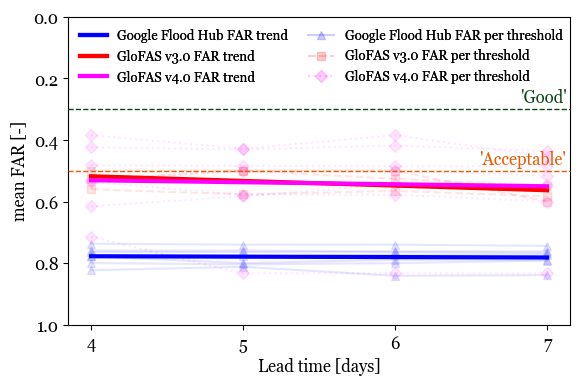

In [ ]:
print(df_GFH_OBS_FAR_total)
# print(df_GFH_OBS_FAR_total)
print(df_GloFAS_v3_OBS_FAR_total)
# print(df_GloFAS_v3_OBS_FAR_total)
print(df_GloFAS_v4_OBS_FAR_total)
# print(df_GloFAS_v4_OBS_FAR_total)

# plot lead time on the x-axis and POD on the y-axis
fig, ax = plt.subplots(figsize = (4 * 1.618, 4))
fs = 12


def plot_all_thresholds(ax, df, color, marker, ls = '-', alpha = 0.5,
                        exclude_cols: Optional[List[str]] = None):
    if exclude_cols is not None:
        df = df.drop(columns = exclude_cols)
    for col in df.columns:  
        ax.plot(
            df.index, df[col],
            color = color,
            marker = marker,
            linestyle = ls, alpha = alpha
        )

alpha = 0.1
exclude_cols_glofas3 = ['95pc', '98pc', '99pc', '10rp']
plot_all_thresholds(ax, df_GFH_OBS_FAR_total,
                    'blue',    '^', '-', alpha = alpha)
plot_all_thresholds(ax, df_GloFAS_v3_OBS_FAR_total,
                    'red',     's', '--', alpha = alpha,
                    exclude_cols = exclude_cols_glofas3)
plot_all_thresholds(ax, df_GloFAS_v4_OBS_FAR_total,
                    'magenta', 'D', ':', alpha = alpha)

ax.set_ylim(0, 1)
ax.tick_params(axis = 'y', labelsize = fs)
ax.set_ylabel('mean FAR [-]', fontsize = fs)
ax.set_xticks(df_GFH_IMPACT_POD_total.index)
ax.set_xticklabels([4, 5, 6, 7], fontsize = fs)
ax.set_xlabel('Lead time [days]', fontsize = fs)
ax.set_ylim(1, 0)

add_hline_across_subplots(
    fig, ax, 0.5, ax, ax, label = "'Acceptable'",
    color = '#EB5B00', linestyle = '--', linewidth = 1.0
)
add_hline_across_subplots(
    fig, ax, 0.3, ax, ax, label = "'Good'",
    color = '#0D4715', linestyle = '--', linewidth = 1.0
)

# add legend 
# add first legend
legend_handles_1 = [
    # GFH trend
    mpl.lines.Line2D([0], [0], color = 'blue', linestyle = '-',
                     alpha = 1, linewidth = 3),
    # GloFAS v3 trend
    mpl.lines.Line2D([0], [0], color = 'red', linestyle = '-',
                     alpha = 1, linewidth = 3),
    # GloFAS v4 trend
    mpl.lines.Line2D([0], [0], color = 'magenta', linestyle = '-',
                     alpha = 1, linewidth = 3),
    # GFH
     mpl.lines.Line2D([0], [0], color = 'blue', marker = '^', linestyle = '-',
                      alpha = alpha + 0.0),
    # GloFAS v3
     mpl.lines.Line2D([0], [0], color = 'red', marker = 's', linestyle = '--',
                      alpha = alpha + 0.0),
    # GloFAS v4
     mpl.lines.Line2D([0], [0], color = 'magenta', marker = 'D', linestyle = ':',
                      alpha = alpha + 0.0),
]
legend_labels_1 = ['Google Flood Hub FAR trend',
                   'GloFAS v3.0 FAR trend',
                   'GloFAS v4.0 FAR trend',
                   'Google Flood Hub FAR per threshold',
                   'GloFAS v3.0 FAR per threshold',
                   'GloFAS v4.0 FAR per threshold']
legend_1 = ax.legend(legend_handles_1, legend_labels_1,
          fontsize = fs - 2.5, ncol = 2, frameon = False, loc = 'upper left',
          columnspacing = 1.5)
ax.add_artist(legend_1)

# LLM-generated code-block:
def add_mean_and_trend(ax, df, color, marker, label, exclude_cols=None,
                       place='above', xshift=100, yshift=6, fontsize=9):
    """
    Draws trend line (mean across thresholds vs lead time) and annotates it
    just above/below the **beginning** of the line (leftmost valid point).
    place: 'above' or 'below'
    """
    if exclude_cols is not None:
        df = df.loc[:, ~df.columns.isin(exclude_cols)]

    x_cat = list(df.index)                              # categorical x (lead times)
    vals  = df.apply(pd.to_numeric, errors='coerce')
    y_mean = vals.mean(axis=1).reindex(x_cat).to_numpy()

    x_num = np.arange(len(x_cat))
    msk = ~np.isnan(y_mean)
    if msk.sum() >= 2:
        m, b = np.polyfit(x_num[msk], y_mean[msk], 1)
        y_trend = m * x_num + b
    else:
        y_trend = np.full_like(x_num, np.nan, dtype=float)

    # plot trend
    ax.plot(x_cat, y_trend, color=color, linewidth=3, alpha=1, linestyle='-')

    # annotate at the **start** (first finite point)
    idx = np.where(np.isfinite(y_trend))[0]
    if len(idx) == 0:
        return
    i0 = idx[0]  # first finite point (leftmost)
    va = 'bottom' if place == 'above' else 'top'
    dy = yshift if place == 'above' else -yshift

    # ax.annotate(f"{label} trend", (x_cat[i0], y_trend[i0]),
    #             xytext=(xshift, dy), textcoords='offset points',
    #             ha='right', va=va, fontsize=fontsize,
    #             fontweight='bold', color=color)

add_mean_and_trend(ax, df_GFH_OBS_FAR_total,       'blue',    '^',
                   'Google Flood Hub')
add_mean_and_trend(ax, df_GloFAS_v3_OBS_FAR_total, 'red',     's',
                   'GloFAS v3.0',
                   exclude_cols = exclude_cols_glofas3)
add_mean_and_trend(ax, df_GloFAS_v4_OBS_FAR_total, 'magenta', 'D',
                   'GloFAS v4.0',
                   place = 'below')

# plt.savefig(f'../data/figures/results_FAR_trend_vs_leadtime.pdf',
#                 bbox_inches = 'tight', dpi = 300)
plt.show()

        95pc   98pc   99pc  1.5rp    2rp    5rp 10rp
96lt   0.309  0.333  0.312  0.543  0.645  0.625  0.8
120lt  0.309  0.364  0.312  0.543  0.645  0.625  0.8
144lt  0.309  0.303  0.312  0.543  0.645  0.625  0.8
168lt  0.309  0.303  0.312  0.543  0.645  0.625  0.8
      95pc 98pc 99pc    1.5rp       2rp       5rp 10rp
96lt   0.0  0.0  0.0  0.34375  0.321429  0.214286  0.0
120lt  0.0  0.0  0.0  0.34375  0.321429  0.214286  0.0
144lt  0.0  0.0  0.0   0.3125  0.321429  0.142857  0.0
168lt  0.0  0.0  0.0   0.3125  0.321429  0.142857  0.0
           95pc      98pc     99pc    1.5rp       2rp       5rp 10rp
96lt   0.641509  0.575758  0.46875  0.46875  0.357143  0.571429  0.4
120lt  0.622642  0.575758      0.5      0.5  0.357143  0.571429  0.2
144lt  0.603774  0.575758   0.5625  0.53125  0.392857  0.571429  0.2
168lt  0.584906  0.606061   0.5625  0.46875  0.357143  0.428571  0.2


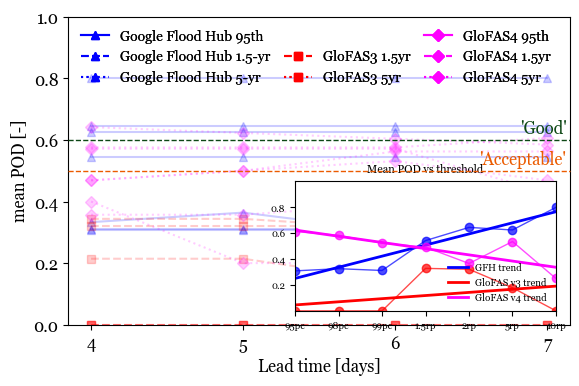

In [70]:
print(df_GFH_OBS_POD_total)
# print(df_GFH_OBS_FAR_total)
print(df_GloFAS_v3_OBS_POD_total)
# print(df_GloFAS_v3_OBS_FAR_total)
print(df_GloFAS_v4_OBS_POD_total)
# print(df_GloFAS_v4_OBS_FAR_total)

# select only the 95pc, 1.5rp, 5rp columns
# df_GFH_OBS_POD_total_subset = df_GFH_OBS_POD_total.loc[:, ['95pc', '1.5rp', '5rp']]
# df_GFH_OBS_FAR_total_subset = df_GFH_OBS_FAR_total.loc[:, ['95pc', '1.5rp', '5rp']]
# df_GloFAS_v4_OBS_POD_total_subset = df_GloFAS_v4_OBS_POD_total.loc[:, ['95pc', '1.5rp', '5rp']]
# df_GloFAS_v4_OBS_FAR_total_subset = df_GloFAS_v4_OBS_FAR_total.loc[:, ['95pc', '1.5rp', '5rp']]
# df_GloFAS_v3_OBS_POD_total_subset = df_GloFAS_v3_OBS_POD_total.loc[:, ['95pc', '1.5rp', '5rp']]
# df_GloFAS_v3_OBS_FAR_total_subset = df_GloFAS_v3_OBS_FAR_total.loc[:, ['95pc', '1.5rp', '5rp']]

# plot lead time on the x-axis and POD on the y-axis
fig, ax = plt.subplots(figsize = (4 * 1.618, 4))
fs = 12

# # plot every line separately: take the index as x and take a column as y per plot:
# # linestyles = ['-', '--', ':']
# linestyles = ['--']
# alpha = 0.2
# for col, ls in zip(df_GFH_OBS_POD_total.columns, linestyles):
#     print(df_GFH_OBS_POD_total.index)
#     ax.plot(
#         df_GFH_OBS_POD_total.index, df_GFH_OBS_POD_total[col],
#         color = 'blue', marker = '^', linestyle = ls, alpha = alpha
#     )
#     print(f'plotted column {col} linestyle {ls}')
# for col, ls in zip(df_GloFAS_v3_OBS_POD_total.columns, linestyles):
#     if col == '95pc':
#         continue
#     ax.plot(
#         df_GloFAS_v3_OBS_POD_total.index, df_GloFAS_v3_OBS_POD_total[col],
#         color = 'red', marker = 's', linestyle = ls, alpha = alpha
#     )
# for col, ls in zip(df_GloFAS_v4_OBS_POD_total.columns, linestyles):
#     ax.plot(
#         df_GloFAS_v4_OBS_POD_total.index, df_GloFAS_v4_OBS_POD_total[col],
#         color = 'magenta', marker = 'D', linestyle = ls, alpha = alpha
#     )

# linestyles = ['-', '--', ':', '-.', (0, (5, 1)), (0, (3, 1, 1, 1)), (0, (1, 1))]

def plot_all_thresholds(ax, df, color, marker, ls = '-', alpha = 0.5):
    for col in df.columns:  # plot EVERY threshold column
        ax.plot(
            df.index, df[col],
            color = color,
            marker = marker,
            linestyle = ls, alpha = alpha
        )

plot_all_thresholds(ax, df_GFH_OBS_POD_total,
                    'blue',    '^', '-', alpha = alpha)
plot_all_thresholds(ax, df_GloFAS_v3_OBS_POD_total,
                    'red',     's', '--', alpha = alpha)
plot_all_thresholds(ax, df_GloFAS_v4_OBS_POD_total,
                    'magenta', 'D', ':', alpha = alpha)

ax.set_ylim(0, 1)
ax.tick_params(axis = 'y', labelsize = fs)
ax.set_ylabel('mean POD [-]', fontsize = fs)
ax.set_xticks(df_GFH_IMPACT_POD_total.index)
ax.set_xticklabels([4, 5, 6, 7], fontsize = fs)
ax.set_xlabel('Lead time [days]', fontsize = fs)

add_hline_across_subplots(
    fig, ax, 0.5, ax, ax, label = "'Acceptable'",
    color = '#EB5B00', linestyle = '--', linewidth = 1.0
)
add_hline_across_subplots(
    fig, ax, 0.6, ax, ax, label = "'Good'",
    color = '#0D4715', linestyle = '--', linewidth = 1.0
)

# add legend 
# add first legend
legend_handles_1 = [
    # GFH
     mpl.lines.Line2D([0], [0], color = 'blue', marker = '^', linestyle = '-'),
     mpl.lines.Line2D([0], [0], color = 'blue', marker = '^', linestyle = '--'),
     mpl.lines.Line2D([0], [0], color = 'blue', marker = '^', linestyle = ':'),
    # GloFAS v3
    #  mpl.lines.Line2D([0], [0], color = 'red', marker = 's', linestyle = '-'),
     mpl.lines.Line2D([0], [0], marker = 's', linestyle = 'None',
                     markerfacecolor = 'none', markeredgecolor = 'none'),
     mpl.lines.Line2D([0], [0], color = 'red', marker = 's', linestyle = '--'),
     mpl.lines.Line2D([0], [0], color = 'red', marker = 's', linestyle = ':'),
    # GloFAS v4
     mpl.lines.Line2D([0], [0], color = 'magenta', marker = 'D', linestyle = '-'),
     mpl.lines.Line2D([0], [0], color = 'magenta', marker = 'D', linestyle = '--'),
     mpl.lines.Line2D([0], [0], color = 'magenta', marker = 'D', linestyle = ':'),
]
legend_labels_1 = ['Google Flood Hub 95th', 'Google Flood Hub 1.5-yr', 'Google Flood Hub 5-yr',
                   '', 'GloFAS3 1.5yr', 'GloFAS3 5yr',
                   'GloFAS4 95th', 'GloFAS4 1.5yr', 'GloFAS4 5yr']
legend_1 = ax.legend(legend_handles_1, legend_labels_1,
          fontsize = fs - 2, ncol = 3, frameon = False, loc = 'upper left', columnspacing = 1)
ax.add_artist(legend_1)
# add second legend
# legend_handles_2 = [
#     mpl.lines.Line2D([0], [0], color = 'blue', marker = '^', linestyle = '-'),
#     mpl.lines.Line2D([0], [0], color = 'red', marker = 's', linestyle = '-'),
#     mpl.lines.Line2D([0], [0], color = 'magenta', marker = 'D', linestyle = '-'),
# ]
# legend_labels_2 = ['Google Flood Hub', 'GloFAS v3', 'GloFAS v4']
# legend_2 = ax.legend(legend_handles_2, legend_labels_2,
#           fontsize = fs, ncol = 3, frameon = False, loc = 'lower left',
#           columnspacing = 1)


import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# --- Inset showing mean POD vs threshold (one trend line per model) ---
# Use the same column order as in your DataFrames:
thr_cols = list(df_GFH_OBS_POD_total.columns)  # e.g. ['95pc','98pc','99pc','1.5rp','2rp','5rp','10rp']
x_num = np.arange(len(thr_cols))

# Create inset axis (adjust size/loc to taste)
ax_in = inset_axes(ax, width="52%", height="42%", loc="lower right", borderpad=1.0)

def add_threshold_trend(df, color, label):
    # Ensure we use the same threshold order; fill missing ones with NaN
    vals = df.reindex(columns=thr_cols).apply(pd.to_numeric, errors='coerce')

    # Mean across lead times for each threshold (column-wise)
    means = vals.mean(axis=0).to_numpy()

    # Fit a simple linear trend, skipping NaNs if any
    mask = ~np.isnan(means)
    x_fit = x_num[mask]
    y_fit = means[mask]

    # plot points + trend (only fit if we have ≥2 points)
    ax_in.plot(x_num, means, marker='o', lw=1, color=color, alpha=0.7)
    if len(y_fit) >= 2:
        m, b = np.polyfit(x_fit, y_fit, 1)
        ax_in.plot(x_num, m*x_num + b, color=color, lw=2, label=label)
    else:
        # no fit possible; still add a label for consistency
        ax_in.plot([], [], color=color, lw=2, label=label)

# One line per model (colors/labels consistent with main plot)
add_threshold_trend(df_GFH_OBS_POD_total,      'blue',    'GFH trend')
add_threshold_trend(df_GloFAS_v3_OBS_POD_total,'red',     'GloFAS v3 trend')
add_threshold_trend(df_GloFAS_v4_OBS_POD_total,'magenta', 'GloFAS v4 trend')

# Cosmetics for inset
ax_in.set_ylim(0, 1)
ax_in.set_xlim(x_num.min(), x_num.max())
ax_in.set_xticks(x_num)
ax_in.set_xticklabels(thr_cols, fontsize=7, rotation=0)
ax_in.set_yticks([0.2, 0.4, 0.6, 0.8])
ax_in.tick_params(axis='y', labelsize=7)
ax_in.set_title('Mean POD vs threshold', fontsize=8)
ax_in.grid(False)
ax_in.legend(frameon=False, fontsize=7, loc='lower right')

# plt.savefig(f'../data/figures/results_POD_vs_leadtime.pdf',
#                 bbox_inches = 'tight', dpi = 300)
plt.show()

### **Make barbell plot to show POD for 4-day vs 7-day lead time difference effectively**

In [59]:
# make a list which will become the y-axis labels
y_labels = [
    'GFH 95th',
    'GFH 98th',
    'GFH 99th',
    'GFH 1.5rp',
    'GFH 2rp',
    'GFH 5rp',
    'GFH 10rp',
    'GloFAS v3 95th',
    'GloFAS v3 98th',
    'GloFAS v3 99th',
    'GloFAS v3 1.5rp',
    'GloFAS v3 2rp',
    'GloFAS v3 5rp',
    'GloFAS v3 10rp',
    'GloFAS v4 95th',
    'GloFAS v4 98th',
    'GloFAS v4 99th',
    'GloFAS v4 1.5rp',
    'GloFAS v4 2rp',
    'GloFAS v4 5rp',
    'GloFAS v4 10rp'
]
df_plot = pd.DataFrame(index = y_labels,
                       columns = ['model', 'POD_96lt', 'POD_168lt'])
print(df_plot)
models = ['GFH', 'GloFAS3', 'GloFAS4']
dfs = [df_GFH_OBS_POD_total,
       df_GloFAS_v3_OBS_POD_total,
       df_GloFAS_v4_OBS_POD_total]
for model, df in zip(models, dfs):
    values_96lt_POD = df.loc['96lt', :].values
    values_168lt_POD = df.loc['168lt', :].values
    # for the correct y_labels, we need to find the start index
    if model == 'GFH':
        start_idx = 0
    elif model == 'GloFAS3':
        start_idx = 7
    elif model == 'GloFAS4':
        start_idx = 14
    idx_range = y_labels[start_idx : start_idx + 7]
    print(idx_range)
    print(model, len(values_96lt_POD), len(idx_range))
    df_plot.loc[idx_range, 'model'] = model
    print(df_plot.loc[idx_range])
    df_plot.loc[idx_range, 'POD_96lt'] = values_96lt_POD
    df_plot.loc[idx_range, 'POD_168lt'] = values_168lt_POD
    print(df_plot)

df_plot['difference'] = pd.to_numeric(df_plot['POD_168lt']) - \
                        pd.to_numeric(df_plot['POD_96lt'])
print(df_plot)



                model POD_96lt POD_168lt
GFH 95th          NaN      NaN       NaN
GFH 98th          NaN      NaN       NaN
GFH 99th          NaN      NaN       NaN
GFH 1.5rp         NaN      NaN       NaN
GFH 2rp           NaN      NaN       NaN
GFH 5rp           NaN      NaN       NaN
GFH 10rp          NaN      NaN       NaN
GloFAS v3 95th    NaN      NaN       NaN
GloFAS v3 98th    NaN      NaN       NaN
GloFAS v3 99th    NaN      NaN       NaN
GloFAS v3 1.5rp   NaN      NaN       NaN
GloFAS v3 2rp     NaN      NaN       NaN
GloFAS v3 5rp     NaN      NaN       NaN
GloFAS v3 10rp    NaN      NaN       NaN
GloFAS v4 95th    NaN      NaN       NaN
GloFAS v4 98th    NaN      NaN       NaN
GloFAS v4 99th    NaN      NaN       NaN
GloFAS v4 1.5rp   NaN      NaN       NaN
GloFAS v4 2rp     NaN      NaN       NaN
GloFAS v4 5rp     NaN      NaN       NaN
GloFAS v4 10rp    NaN      NaN       NaN
['GFH 95th', 'GFH 98th', 'GFH 99th', 'GFH 1.5rp', 'GFH 2rp', 'GFH 5rp', 'GFH 10rp']
GFH 7 7
      

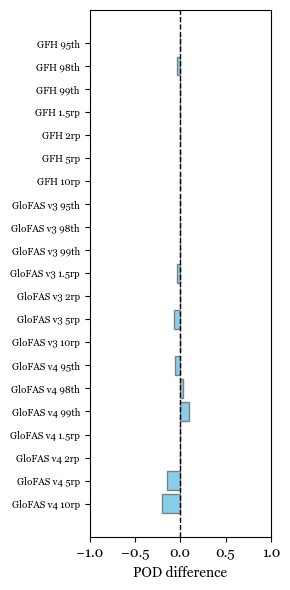

In [67]:
labels = df_plot.index.tolist()
diffs = df_plot['difference'].values

fig, ax = plt.subplots(figsize=(3, 6))  # adjust height for 21 entries
y_pos = np.arange(len(labels))
# plt.subplots_adjust(top=0.80, bottom=0.20)  # shrink vertical margins
ax.barh(y_pos, diffs, color='skyblue', edgecolor='grey')
ax.axvline(0, color='black', linestyle='--', linewidth=1)

# y-axis labels
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize = 7)   
ax.invert_yaxis()

# x-axis settings
ax.set_xlim(-1.0, 1.0)                   # domain from -1 to 1
ax.set_xlabel('POD difference', fontsize = 10)

plt.tight_layout()
plt.show()